### NOTE: This notebook only includes atomic-cooling galaxies with PopII stars. Pop III stars in minihalos have not been added to this module yet.

This tutorial will cover how to generate UVLFs from Zeus21. It is recommended to do the basics tutorial first, to get a handle on how the code works. That said, this can stand on its own, so let's go!

In [1]:
import zeus21
from matplotlib import pyplot as plt
import numpy as np
import copy


#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

#and the user parameters
UserParams = zeus21.User_Parameters(precisionboost=1.2)

Now we set up the cosmology and astrophysics. We do not need to go as far as the 21-cm calculation when doing UVLFs. We do not need the Coeff or PS21 structures (since we won't compute 21-cm in this tutorial), nor do we need the correlation functions. We do need the HMFs, though.

As before, we begin by running CLASS, where you can change the input parameters as shown below. Then we save the cosmo parameters, the correlation functions, and the halo mass function at all desired z and M. T

Then we set up the astro parameters. They're shared between the UVLF and the 21-cm calculation so one can jointly do inference.

In [2]:
CosmoParams_input = zeus21.Cosmo_Parameters_Input(zmin_CLASS=0.0) #make sure to provide zmin_CLASS lower than standard (5.0) if you want lower z results (eg HMFs)

CosmoParams,ClassyCosmo, CorrFclass ,HMFintclass =  zeus21.cosmo_wrapper(UserParams, CosmoParams_input)

Now we have to define the astrophysical parameters. You can run with the default set, but let's spice things up a bit. Let's define two:
-One with a standard halo-galaxy connection
-One with a very stochastic halo-galaxy connection, but lower UV brightness per galaxy (smaller f* at peak)

In [3]:
AstroParams_std = zeus21.Astro_Parameters(UserParams, CosmoParams, accretion_model=0) #made accretion_model exponential, like in the paper (2306.09403)
AstroParams_bursty = zeus21.Astro_Parameters(UserParams, CosmoParams, sigmaUV=0.9, accretion_model=0) #made accretion_model exponential, like in the paper (2306.09403)

Now define the redshift and magnitudes over which to plot. You give an arbitrary <z> and width dz, and the code will assume the selection function is a Gaussian around it. For magnitudes you provide centers and widths of bins, assumed to be tophats. It will then generate the UVLF under those specs. Make sure the binning of z and MUV are the same as whatever date you're considering!

In [4]:
z, dz = 6.0, 0.5 #zcentral and width (assumed Gaussian)

MUVcenters = np.linspace(-12,-23,23) #centers of bins
MUVwidths = -np.diff(MUVcenters)
MUVwidths = np.append(MUVwidths,MUVwidths[-1])
#print(MUVcenters)

/Users/julian/opt/anaconda3/envs/21cmclass/lib/python3.7/site-packages/zeus21/UVLFs.py:30: RuntimeWarning: divide by zero encountered in log10
  MUVtab = 51.63 - 2.5 * np.log10(LUVtab) #AB magnitude


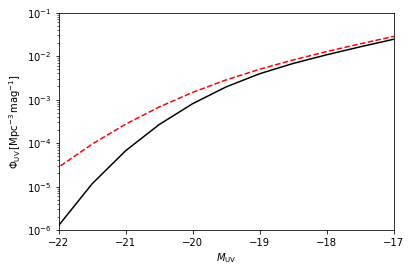

In [5]:
UVLFs_std = zeus21.UVLFs.UVLF_binned(AstroParams_std,CosmoParams,HMFintclass,z,dz,MUVcenters,MUVwidths)
UVLFs_bursty = zeus21.UVLFs.UVLF_binned(AstroParams_bursty,CosmoParams,HMFintclass,z,dz,MUVcenters,MUVwidths)


plt.semilogy(MUVcenters,UVLFs_std,'k-')
plt.semilogy(MUVcenters,UVLFs_bursty,'r--')
plt.xlim(-22,-17)
plt.ylim(1e-6,1e-1)
plt.xlabel(r'$M_{\rm UV}$');
plt.ylabel(r'$\Phi_{\rm UV}\,\rm [Mpc^{-3}\,mag^{-1}]$');

If you're new to the world of UVLFs note that the x axis is a UV absolute magnitude, and y is the comoving number density of galaxies at that magnitude (divided by the width of the bin)

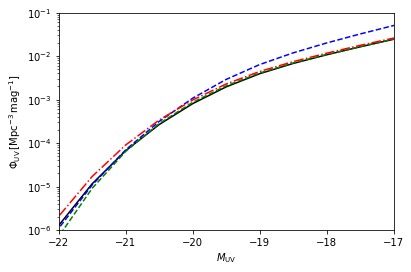

In [6]:
#now let's change the alpha and beta too to see what they do
AstroParams_lowalpha = copy.deepcopy(AstroParams_std)
AstroParams_lowalpha.alphastar-=0.2
UVLFs_lowalpha = zeus21.UVLFs.UVLF_binned(AstroParams_lowalpha,CosmoParams,HMFintclass,z,dz,MUVcenters,MUVwidths)

AstroParams_lowbeta = copy.deepcopy(AstroParams_std)
AstroParams_lowbeta.betastar-=0.2
UVLFs_lowbeta = zeus21.UVLFs.UVLF_binned(AstroParams_lowbeta,CosmoParams,HMFintclass,z,dz,MUVcenters,MUVwidths)

#and the dust assumptions -- they can be degenerate! (Beware, these are measured independently, see Refs.)
AstroParams_lessdust = copy.deepcopy(AstroParams_std)
AstroParams_lessdust.C0dust-=0.1;
UVLFs_lessdust = zeus21.UVLFs.UVLF_binned(AstroParams_lessdust,CosmoParams,HMFintclass,z,dz,MUVcenters,MUVwidths)


plt.semilogy(MUVcenters,UVLFs_std,'k-')
plt.semilogy(MUVcenters,UVLFs_lowalpha,'b--')
plt.semilogy(MUVcenters,UVLFs_lowbeta,'g--')
plt.semilogy(MUVcenters,UVLFs_lessdust,'r-.')
plt.xlim(-22,-17)
plt.ylim(1e-6,1e-1)
plt.xlabel(r'$M_{\rm UV}$');
plt.ylabel(r'$\Phi_{\rm UV}\,\rm [Mpc^{-3}\,mag^{-1}]$');


Zeus allows to compute the bias as a function of MUV as well. Let's do that and plot it!

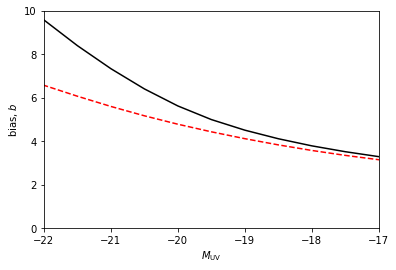

In [7]:

bias_UVLFs_std = zeus21.UVLFs.UVLF_binned(AstroParams_std,CosmoParams,HMFintclass,z,dz,MUVcenters,MUVwidths,RETURNBIAS=True)/UVLFs_std
bias_UVLFs_bursty = zeus21.UVLFs.UVLF_binned(AstroParams_bursty,CosmoParams,HMFintclass,z,dz,MUVcenters,MUVwidths,RETURNBIAS=True)/UVLFs_bursty
#note it's divided by UVLF, since the bias returns <b>*Phi on each MUV bin, so you have to divide by UVLF to get the bias alone

plt.plot(MUVcenters,bias_UVLFs_std,'k-')
plt.plot(MUVcenters,bias_UVLFs_bursty,'r--')
plt.xlim(-22,-17)
plt.ylim(0,10)
plt.xlabel(r'$M_{\rm UV}$');
plt.ylabel(r'bias, $b$');

In [18]:
#and the newly added pop3 UVLF
AstroParams_popIII = zeus21.Astro_Parameters(UserParams, CosmoParams, accretion_model=0, USE_POPIII=True,betastar_III=-0.3) 

In [19]:
import pandas as pd

data = {
    'MUV': [-19.5, -18.5, -17.5, -16.5, -15.5, -14.5],
   'phi': [0.16e-5, 0.35e-5, 0.64e-5, 5.0e-5, 18.0e-5, 226.5e-5],
   'phi_upper': [0.16e-5, 0.35e-5, 2.1e-5, 5.0e-5, 59.4e-5, 226.5e-5],
   'phi_lower': [0, 0, 0.11e-5, 0, 4.0e-5, 0],
    'is_upper_limit': [True, True, False, True, False, True]
}

df = pd.DataFrame(data)

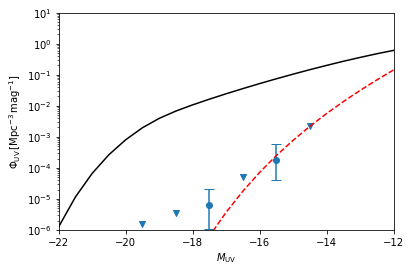

In [20]:
UVLFs_pop2,UVLFs_pop3= zeus21.UVLFs.UVLF_binned(AstroParams_popIII,CosmoParams,HMFintclass,z,dz,MUVcenters,MUVwidths)

# Plot points with error bars
measured = ~df['is_upper_limit']
plt.errorbar(df[measured]['MUV'], df[measured]['phi'],
            yerr=[df[measured]['phi'] - df[measured]['phi_lower'],
                  df[measured]['phi_upper'] - df[measured]['phi']],
            fmt='o', capsize=5, label='Measurements')

# Plot upper limits
limits = df['is_upper_limit']
plt.scatter(df[limits]['MUV'], df[limits]['phi'], 
           marker='v', label='Upper limits')



plt.semilogy(MUVcenters,UVLFs_pop2,'k-')
plt.semilogy(MUVcenters,UVLFs_pop3,'r--')
plt.xlim(-22,-12)
plt.ylim(1e-6,1e1)
plt.xlabel(r'$M_{\rm UV}$');
plt.ylabel(r'$\Phi_{\rm UV}\,\rm [Mpc^{-3}\,mag^{-1}]$');

In [21]:
_zz = 10.; 
from scipy.interpolate import interp1d
_J21interptemp = interp1d(np.linspace(0,100,3), np.zeros(3), kind = 'linear', bounds_error = False, fill_value = 0,) #TODO: how to deal with J21, requires running get_21_coefficients

SFRlist_III = zeus21.sfrd.SFR_III(AstroParams_popIII, CosmoParams, HMFintclass, HMFintclass.Mhtab, _J21interptemp, _zz, _zz, CosmoParams.vcb_avg)
SFRlist_II = zeus21.sfrd.SFR_II(AstroParams_popIII,CosmoParams,HMFintclass, HMFintclass.Mhtab, _zz, _zz)

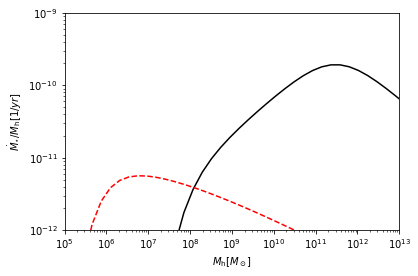

In [22]:
plt.loglog(HMFintclass.Mhtab,SFRlist_II/HMFintclass.Mhtab,'k-')
plt.loglog(HMFintclass.Mhtab,SFRlist_III/HMFintclass.Mhtab,'r--')
plt.xlim(1e5,1e13)
plt.ylim(1e-12,1e-9)
plt.xlabel(r'$M_{\rm h}[M_\odot]$');
plt.ylabel(r'$\dot M_{\star}/M_{\rm h} [1/yr]$');

(1e-12, 1e-08)

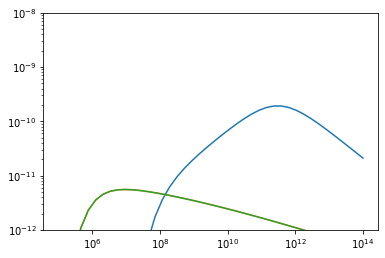

In [13]:
def fstarofz_III(Astro_Parameters, Cosmo_Parameters, z, Mhlist):
    epsstar_ofz_III = Astro_Parameters.fstar_III * 10**(Astro_Parameters.dlog10epsstardz_III * (z-Astro_Parameters._zpivot_III) )
    if Cosmo_Parameters.Flag_emulate_21cmfast == False:
        return 2 * Cosmo_Parameters.OmegaB/Cosmo_Parameters.OmegaM * epsstar_ofz_III\
    /(pow(Mhlist/Astro_Parameters.Mc_III, -Astro_Parameters.alphastar_III) + pow(Mhlist/Astro_Parameters.Mc_III, -Astro_Parameters.betastar_III))
    elif Cosmo_Parameters.Flag_emulate_21cmfast == True:
        return Cosmo_Parameters.OmegaB/Cosmo_Parameters.OmegaM * epsstar_ofz_III/(pow(Mhlist/Astro_Parameters.Mc_III, -Astro_Parameters.alphastar_III))
    

def Matom(z):
    "Returns Matom as a function of z"
    return 3.3e7 * pow((1.+z)/(21.),-3./2)

def Mmol_0(z):
    "Returns Mmol as a function of z WITHOUT LW or VCB feedback"
    return 3.3e7 * (1.+z)**(-1.5)

def Mmol_vcb(Astro_Parameters, Cosmo_Parameters, z, vCB):
    "Returns Mmol as a function of z WITHOUT LW feedback"
    mmolBase = Mmol_0(z)
    vcbFeedback = pow(1 + Astro_Parameters.A_vcb * vCB / Cosmo_Parameters.sigma_vcb, Astro_Parameters.beta_vcb)
    return mmolBase * vcbFeedback

def SFR_III_alt(Astro_Parameters, Cosmo_Parameters, HMF_interpolator, massVector, J21LW_interp, z, z2, vCB):
    "PopIII SFR in Msun/yr at redshift z. Evaluated at the halo masses Mh [Msun] of the HMF_interpolator, given Astro_Parameters"
    if(Astro_Parameters.USE_POPIII == False):
        return 0 #skip whole routine if NOT using PopIII stars
    else:
        Mh = massVector
        
        if(Cosmo_Parameters.Flag_emulate_21cmfast==False): #in 21cmfast it uses a backwarsd time z2>z, but in general it should not
            z2 = z    
        fduty_III =  np.exp(-Mmol_vcb(Astro_Parameters, Cosmo_Parameters, z2, vCB)/Mh)
        
        fstarM_III = fstarofz_III(Astro_Parameters, Cosmo_Parameters, z, Mh)
        fstarM_III = np.fmin(fstarM_III, Astro_Parameters.fstarmax)
        
        return zeus21.sfrd.dMh_dt(Astro_Parameters, Cosmo_Parameters, HMF_interpolator, Mh, z) * fstarM_III * fduty_III
    

SFRlist_III_alt = SFR_III_alt(AstroParams_popIII, CosmoParams, HMFintclass, HMFintclass.Mhtab, _J21interptemp, _zz, _zz, CosmoParams.vcb_avg)
    

plt.loglog(HMFintclass.Mhtab,SFRlist_II/HMFintclass.Mhtab)
plt.loglog(HMFintclass.Mhtab,SFRlist_III_alt/HMFintclass.Mhtab)
plt.loglog(HMFintclass.Mhtab,SFRlist_III/HMFintclass.Mhtab)
plt.ylim(1e-12,1e-8)

In [14]:
#and combine to get UVLF:
def UVLF_binned(Astro_Parameters,Cosmo_Parameters,HMF_interpolator, zcenter, zwidth, MUVcenters, MUVwidths, DUST_FLAG=True, RETURNBIAS = False):
    'Binned UVLF in units of 1/Mpc^3/mag, for bins at <zcenter> with a Gaussian width zwidth, centered at MUV centers with tophat width MUVwidths. z width only in HMF since that varies the most rapidly. If flag RETURNBIAS set to true it returns number-avgd bias instead of UVLF, still have to divide by UVLF'
    
    if(constants.NZ_TOINT>1):
        DZ_TOINT = np.linspace(-np.sqrt(constants.NZ_TOINT/3.),np.sqrt(constants.NZ_TOINT/3.),constants.NZ_TOINT) #in sigmas around zcenter
    else:
        DZ_TOINT = np.array([0.0])
    WEIGHTS_TOINT = np.exp(-DZ_TOINT**2/2.)/np.sum(np.exp(-DZ_TOINT**2/2.)) #assumed Gaussian in z, fair



    
    SFRlist = SFR_II(Astro_Parameters,Cosmo_Parameters,HMF_interpolator, HMF_interpolator.Mhtab, zcenter, zcenter)
    sigmaUV = Astro_Parameters.sigmaUV
    
    if (constants.FLAG_RENORMALIZE_LUV == True): #lower the LUV (or SFR) to recover the true avg, not log-avg
        SFRlist/= np.exp((np.log(10)/2.5*sigmaUV)**2/2.0)
        
    MUVbarlist = MUV_of_SFR(SFRlist, Astro_Parameters._kappaUV) #avg for each Mh
    MUVbarlist = np.fmin(MUVbarlist,constants._MAGMAX)
    

    if(RETURNBIAS==True): # weight by bias
        biasM = np.array([bias_Tinker(Cosmo_Parameters, HMF_interpolator.sigma_int(HMF_interpolator.Mhtab,zcenter+dz*zwidth)) for dz in DZ_TOINT])
    else: # do not weight by bias
        biasM = np.ones_like(WEIGHTS_TOINT)
 
        
    HMFtab = np.array([HMF_interpolator.HMF_int(HMF_interpolator.Mhtab,zcenter+dz*zwidth) for dz in DZ_TOINT])
    HMFcurr = np.sum(WEIGHTS_TOINT * HMFtab.T * biasM.T,axis=1)

    #cannot directly 'dust' the theory since the properties of the IRX-beta relation are calibrated on observed MUV. Recursion instead:
    currMUV = MUVbarlist
    if(DUST_FLAG==True):
        currMUV2 = np.ones_like(currMUV)
        while(np.sum(np.abs((currMUV2-currMUV)/currMUV)) > 0.02):
            currMUV = MUVbarlist + AUV(Astro_Parameters,zcenter,currMUV)
            currMUV2 = currMUV
           
    
    MUVcuthi = MUVcenters +  MUVwidths/2.
    MUVcutlo = MUVcenters -  MUVwidths/2.
    
    xhi = np.subtract.outer(MUVcuthi, currMUV)/(np.sqrt(2) * sigmaUV)
    xlo = np.subtract.outer(MUVcutlo, currMUV )/(np.sqrt(2) * sigmaUV)
    weights = (erf(xhi) - erf(xlo)).T/(2.0 * MUVwidths)
    
    UVLF_filtered = np.trapz(weights.T * HMFcurr, HMF_interpolator.Mhtab, axis=-1)

    if(Astro_Parameters.USE_POPIII==False):
        return UVLF_filtered
    else:
        _J21interptemp = interp1d(np.linspace(0,100,3), np.zeros(3), kind = 'linear', bounds_error = False, fill_value = 0,) #TODO: how to deal with J21, requires running get_21_coefficients
        SFRlist_III = SFR_III(Astro_Parameters, Cosmo_Parameters, HMF_interpolator, HMF_interpolator.Mhtab, _J21interptemp, zcenter, zcenter, Cosmo_Parameters.vcb_avg)
    
        MUVbarlist_III = MUV_of_SFR(SFRlist_III, Astro_Parameters._kappaUV_III) #avg for each Mh
        MUVbarlist_III = np.fmin(MUVbarlist_III,constants._MAGMAX)
          
        #and the same for popIII, TODO: ignore dust for pop3 for now
        xhi = np.subtract.outer(MUVcuthi, MUVbarlist_III)/(np.sqrt(2) * sigmaUV)
        xlo = np.subtract.outer(MUVcutlo, MUVbarlist_III)/(np.sqrt(2) * sigmaUV)
        weights = (erf(xhi) - erf(xlo)).T/(2.0 * MUVwidths)

        UVLF_filtered_III = np.trapz(weights.T * HMFcurr, HMF_interpolator.Mhtab, axis=-1)
    
        return UVLF_filtered, UVLF_filtered_III